In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, kstest, anderson
import statsmodels.api as sm

# Load data
cvae_latents = torch.load('cvae_latent/cvae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
vae_latents = torch.load('cvae_latent/vae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
labels = torch.load('cvae_latent/labels.pt').cpu().detach().numpy() # shape (10000,)


/tmp/ipykernel_301079/2120236203.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


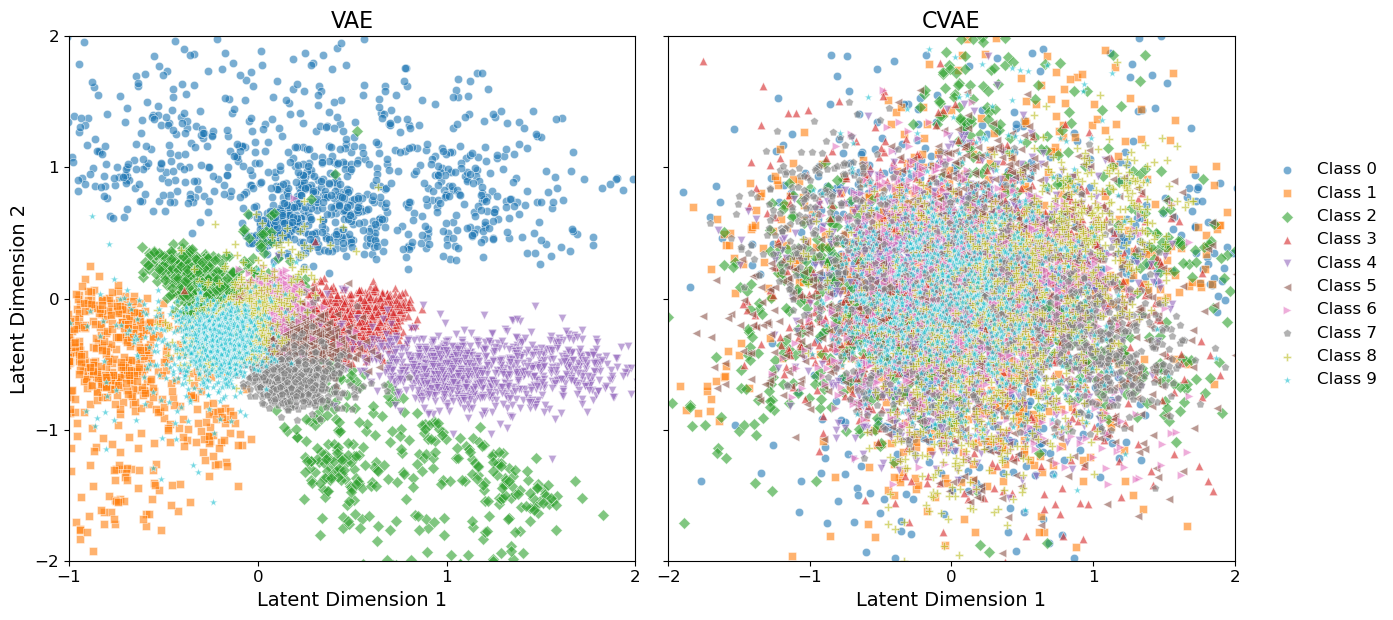

In [2]:
colors = plt.cm.get_cmap('tab10', 10)
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=True)

# Plot VAE latents
for i in range(10):
    idx = labels == i
    axs[0].scatter(vae_latents[idx, 0], vae_latents[idx, 1], color=colors(i), marker=markers[i], label=f'Class {i}', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[0].set_title('VAE', fontsize=16)
axs[0].set_xlabel('Latent Dimension 1', fontsize=14)
axs[0].set_ylabel('Latent Dimension 2', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Plot CVAE latents
for i in range(10):
    idx = labels == i
    axs[1].scatter(cvae_latents[idx, 0], cvae_latents[idx, 1], color=colors(i), marker=markers[i], label=f'Class {i}', alpha=0.6, edgecolors='w', linewidth=0.5)
axs[1].set_title('CVAE', fontsize=16)
axs[1].set_xlabel('Latent Dimension 1', fontsize=14)
# axs[1].set_ylabel('Latent Dimension 2', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

# Ensure the same scale for both plots
axs[0].set_xlim(-1, 2)
axs[0].set_ylim(-2, 2)
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)

# Set x-ticks and y-ticks to show only integers
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Improve legend
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=12, frameon=False)

# Style the plot
plt.tight_layout(rect=[0, 0, 0.9, 0.9])
plt.savefig('latents.png', dpi=300)
plt.show()

# Table without p value

In [1]:
import torch
import numpy as np
import pandas as pd
from scipy.stats import kstest

# Load data
cvae_latents = torch.load('cvae_latent/cvae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
vae_latents = torch.load('cvae_latent/vae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
labels = torch.load('cvae_latent/labels.pt').cpu().detach().numpy() # shape (10000,)

def perform_tests_and_calculate_stats(latents, labels, model_name):
    results = {'class': [], 'dimension': [], 'ks_stat': [], 'ks_p': [], 'model': []}
    unique_labels = np.unique(labels)

    for label in unique_labels:
        class_latents = latents[labels == label]
        
        for j in range(2):
            dimension_latents = class_latents[:, j]
            
            # Kolmogorov-Smirnov Test (two-sided)
            ks_stat, ks_p = kstest(dimension_latents, 'norm')
            
            results['class'].append(label)
            results['dimension'].append(j)
            results['ks_stat'].append(ks_stat)
            results['ks_p'].append(ks_p)
            results['model'].append(model_name)
    
    return pd.DataFrame(results)

# Perform tests and calculate stats for CVAE and VAE
cvae_results = perform_tests_and_calculate_stats(cvae_latents, labels, 'CVAE')
vae_results = perform_tests_and_calculate_stats(vae_latents, labels, 'VAE')

# Combine results into one table
combined_results = pd.concat([cvae_results, vae_results])

# Pivot tables to combine results for dimensions 0 and 1
pivot_table_combined = combined_results.pivot_table(index=['class', 'model'], columns='dimension', values=['ks_stat', 'ks_p'])


# Combine dimension values into single cells using /
pivot_table_combined['ks_stat', 'Combined'] = pivot_table_combined[('ks_stat', 0)].map(lambda x: f'{x:.2g}') + ' / ' + pivot_table_combined[('ks_stat', 1)].map(lambda x: f'{x:.2g}')
pivot_table_combined['ks_p', 'Combined'] = pivot_table_combined[('ks_p', 0)].map(lambda p: str(p < 0.01)) + ' / ' + pivot_table_combined[('ks_p', 1)].map(lambda p: str(p < 0.01))

# Function to add asterisks to significant test statistics
def add_asterisk(stat, sig):
    stat_parts = stat.split(' / ')
    sig_parts = sig.split(' / ')
    return ' / '.join([f'{s}*' if sig == 'True' else s for s, sig in zip(stat_parts, sig_parts)])

# Apply the function to add asterisks
pivot_table_combined['ks_stat', 'Combined'] = pivot_table_combined.apply(lambda row: add_asterisk(row[('ks_stat', 'Combined')], row[('ks_p', 'Combined')]), axis=1)

# Flatten the MultiIndex and keep only combined columns
final_table = pivot_table_combined.loc[:, (slice(None), 'Combined')].reset_index()
final_table.columns = final_table.columns.droplevel(1)

# Split CVAE and VAE columns
cvae_columns = final_table[final_table['model'] == 'CVAE'].drop(columns=['model'])
vae_columns = final_table[final_table['model'] == 'VAE'].drop(columns=['model'])

# Ensure proper columns before renaming
cvae_columns = cvae_columns.rename(columns={('ks_stat'): 'CVAE'})
vae_columns = vae_columns.rename(columns={('ks_stat'): 'VAE'})

# Merge CVAE and VAE columns side by 
merged_table = pd.merge(cvae_columns[['class', 'CVAE']], vae_columns[['class', 'VAE']], on='class')


caption = """Class-Distributions of the CIFAR-10 test set in latent space of CVAE and VAE. 
                Columns show the Kolmogorov-Smirnov Statistics for CVAE and VAE, testing the null hypothesis, that a sample is distributed according to the standard normal distribution. 
                Each cell contains 'Dimension 1 / Dimension 2' results. 
                An asterisk indicates statistical significance at a confidence level of 99\%.
                Lower values indicate better fit to the normal distribution."""
label = 'tab:latents_KS'
                
# Improved LaTeX table formatting
latex_table_combined = merged_table.to_latex(index=False, column_format='lcc', header=True, escape=False)

# Enhance LaTeX formatting for better readability and professional look
latex_table_combined = latex_table_combined.replace('\\toprule', '\\toprule\n & \\multicolumn{2}{c}{\\textbf{KS Statistic}} \\\\\n\\cmidrule(lr){2-3}')
latex_table_combined = latex_table_combined.replace('class & CVAE & VAE', '\\textbf{label} & \\textbf{CVAE} & \\textbf{VAE}')

latex_table_combined = f"\\begin{{table}}[!ht]\n\\centering\n{latex_table_combined}\n\\caption{{{caption}}}\n\\label{{{label}}}\n\\end{{table}}"


# Display LaTeX table
print(latex_table_combined)





<>:72: SyntaxWarning: invalid escape sequence '\%'
<>:72: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4092024/894255030.py:72: SyntaxWarning: invalid escape sequence '\%'
  caption = """Class-Distributions of the CIFAR-10 test set in latent space of CVAE and VAE.


\begin{table}[!ht]
\centering
\begin{tabular}{lcc}
\toprule
 & \multicolumn{2}{c}{\textbf{KS Statistic}} \\
\cmidrule(lr){2-3}
\textbf{label} & \textbf{CVAE} & \textbf{VAE} \\
\midrule
0 & 0.14* / 0.14* & 0.24* / 0.61* \\
1 & 0.15* / 0.15* & 0.59* / 0.42* \\
2 & 0.088* / 0.15* & 0.28* / 0.34* \\
3 & 0.14* / 0.16* & 0.55* / 0.45* \\
4 & 0.17* / 0.14* & 0.69* / 0.56* \\
5 & 0.17* / 0.13* & 0.45* / 0.52* \\
6 & 0.2* / 0.16* & 0.48* / 0.43* \\
7 & 0.13* / 0.15* & 0.47* / 0.64* \\
8 & 0.3* / 0.14* & 0.4* / 0.4* \\
9 & 0.21* / 0.19* & 0.47* / 0.48* \\
\bottomrule
\end{tabular}

\caption{Class-Distributions of the CIFAR-10 test set in latent space of CVAE and VAE. 
                Columns show the Kolmogorov-Smirnov Statistics for CVAE and VAE, testing the null hypothesis, that a sample is distributed according to the standard normal distribution. 
                Each cell contains 'Dimension 1 / Dimension 2' results. 
                An asterisk indicates statistical significance at a confi

## Table with only KS tests

In [83]:
# import torch
# import numpy as np
# import pandas as pd
# from scipy.stats import kstest

# # Load data
# cvae_latents = torch.load('cvae_latent/cvae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
# vae_latents = torch.load('cvae_latent/vae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
# labels = torch.load('cvae_latent/labels.pt').cpu().detach().numpy() # shape (10000,)

# def perform_tests_and_calculate_stats(latents, labels, model_name):
#     results = {'class': [], 'dimension': [], 'ks_stat': [], 'ks_p': [], 'model': []}
#     unique_labels = np.unique(labels)

#     for label in unique_labels:
#         class_latents = latents[labels == label]
        
#         for j in range(2):
#             dimension_latents = class_latents[:, j]
            
#             # Kolmogorov-Smirnov Test (two-sided)
#             ks_stat, ks_p = kstest(dimension_latents, 'norm')
            
#             results['class'].append(label)
#             results['dimension'].append(j)
#             results['ks_stat'].append(ks_stat)
#             results['ks_p'].append(ks_p)
#             results['model'].append(model_name)
    
#     return pd.DataFrame(results)

# # Perform tests and calculate stats for CVAE and VAE
# cvae_results = perform_tests_and_calculate_stats(cvae_latents, labels, 'CVAE')
# vae_results = perform_tests_and_calculate_stats(vae_latents, labels, 'VAE')

# # Combine results into one table
# combined_results = pd.concat([cvae_results, vae_results])

# # Pivot tables to combine results for dimensions 0 and 1
# pivot_table_combined = combined_results.pivot_table(index=['class', 'model'], columns='dimension', 
#                                                     values=['ks_stat', 'ks_p'])

# # Combine dimension values into single cells using /
# for col in ['ks_stat', 'ks_p']:
#     pivot_table_combined[(col, 'Combined')] = pivot_table_combined[(col, 0)].map(lambda x: f'{x:.2g}') + ' / ' + pivot_table_combined[(col, 1)].map(lambda x: f'{x:.2g}')

# # Process p-values to show values larger than 0.01 and indicate "< 0.01" otherwise
# def process_p_value(p):
#     return '$<$ 0.01' if p < 0.01 else f'{p:.2g}'

# pivot_table_combined[('ks_p', 'Combined')] = pivot_table_combined[('ks_p', 0)].map(process_p_value) + ' / ' + pivot_table_combined[('ks_p', 1)].map(process_p_value)

# # Flatten the MultiIndex and keep only combined columns
# final_table = pivot_table_combined.loc[:, (slice(None), 'Combined')].reset_index()

# # Split CVAE and VAE columns
# cvae_columns = final_table[final_table['model'] == 'CVAE'].drop(columns=['model'])
# vae_columns = final_table[final_table['model'] == 'VAE'].drop(columns=['model'])

# # Merge CVAE and VAE columns side by side
# merged_table = pd.merge(cvae_columns, vae_columns, on='class', suffixes=('_CVAE', '_VAE'))
# merged_table.columns = ['Class', 'KS Stat (CVAE)', 'KS p-val (CVAE)', 'KS Stat (VAE)', 'KS p-val (VAE)']

# # Improved LaTeX table formatting
# latex_table_combined = merged_table.to_latex(index=False, column_format='lcccc', header=True, escape=False, 
#                                              caption="Combined Results for CVAE and VAE. Columns show KS Stat: Kolmogorov-Smirnov Statistic and KS p-val: p-value of the KS test. Each cell contains 'Dimension 0 / Dimension 1' results.", label='tab:combined_results')

# # Enhance LaTeX formatting for better readability and professional look
# latex_table_combined = latex_table_combined.replace('\\toprule', '\\toprule\n& \\multicolumn{2}{c}{\\textbf{CVAE}} & \\multicolumn{2}{c}{\\textbf{VAE}} \\\\\n\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}')
# latex_table_combined = latex_table_combined.replace('Class & KS Stat (CVAE) & KS p-val (CVAE) & KS Stat (VAE) & KS p-val (VAE)', '\\textbf{Class} & \\textbf{KS Stat} & \\textbf{KS p-val} & \\textbf{KS Stat} & \\textbf{KS p-val}')


# # Display LaTeX table
# print(latex_table_combined)


\begin{table}
\caption{Combined Results for CVAE and VAE. Columns show KS Stat: Kolmogorov-Smirnov Statistic and KS p-val: p-value of the KS test. Each cell contains 'Dimension 0 / Dimension 1' results.}
\label{tab:combined_results}
\begin{tabular}{lcccc}
\toprule
& \multicolumn{2}{c}{\textbf{CVAE}} & \multicolumn{2}{c}{\textbf{VAE}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
\textbf{Class} & \textbf{KS Stat} & \textbf{KS p-val} & \textbf{KS Stat} & \textbf{KS p-val} \\
\midrule
0 & 0.14 / 0.14 & $<$ 0.01 / $<$ 0.01 & 0.24 / 0.61 & $<$ 0.01 / $<$ 0.01 \\
1 & 0.15 / 0.15 & $<$ 0.01 / $<$ 0.01 & 0.59 / 0.42 & $<$ 0.01 / $<$ 0.01 \\
2 & 0.088 / 0.15 & $<$ 0.01 / $<$ 0.01 & 0.28 / 0.34 & $<$ 0.01 / $<$ 0.01 \\
3 & 0.14 / 0.16 & $<$ 0.01 / $<$ 0.01 & 0.55 / 0.45 & $<$ 0.01 / $<$ 0.01 \\
4 & 0.17 / 0.14 & $<$ 0.01 / $<$ 0.01 & 0.69 / 0.56 & $<$ 0.01 / $<$ 0.01 \\
5 & 0.17 / 0.13 & $<$ 0.01 / $<$ 0.01 & 0.45 / 0.52 & $<$ 0.01 / $<$ 0.01 \\
6 & 0.2 / 0.16 & $<$ 0.01 / $<$ 0.01 & 0.48 / 0.43 & $<

/tmp/ipykernel_279245/1105439754.py:57: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  cvae_columns = final_table[final_table['model'] == 'CVAE'].drop(columns=['model'])
/tmp/ipykernel_279245/1105439754.py:58: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  vae_columns = final_table[final_table['model'] == 'VAE'].drop(columns=['model'])
/tmp/ipykernel_279245/1105439754.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_table = pd.merge(cvae_columns, vae_columns, on='class', suffixes=('_CVAE', '_VAE'))


## Table with means and stds

In [63]:
# import torch
# import numpy as np
# import pandas as pd
# from scipy.stats import kstest

# # Load data
# cvae_latents = torch.load('cvae_latent/cvae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
# vae_latents = torch.load('cvae_latent/vae_latents.pt').cpu().detach().numpy() # shape (10000, 2)
# labels = torch.load('cvae_latent/labels.pt').cpu().detach().numpy() # shape (10000,)

# def perform_tests_and_calculate_stats(latents, labels, model_name):
#     results = {'class': [], 'dimension': [], 'ks_stat': [], 'ks_p': [], 'mean': [], 'std_dev': [], 'model': []}
#     unique_labels = np.unique(labels)

#     for label in unique_labels:
#         class_latents = latents[labels == label]
        
#         for j in range(2):
#             dimension_latents = class_latents[:, j]
            
#             # Kolmogorov-Smirnov Test (two-sided)
#             ks_stat, ks_p = kstest(dimension_latents, 'norm')
            
#             # Calculate mean and standard deviation
#             mean = np.mean(dimension_latents)
#             std_dev = np.std(dimension_latents)
            
#             results['class'].append(label)
#             results['dimension'].append(j)
#             results['ks_stat'].append(ks_stat)
#             results['ks_p'].append(ks_p)
#             results['mean'].append(mean)
#             results['std_dev'].append(std_dev)
#             results['model'].append(model_name)
    
#     return pd.DataFrame(results)

# # Perform tests and calculate stats for CVAE and VAE
# cvae_results = perform_tests_and_calculate_stats(cvae_latents, labels, 'CVAE')
# vae_results = perform_tests_and_calculate_stats(vae_latents, labels, 'VAE')

# # Combine results into one table
# combined_results = pd.concat([cvae_results, vae_results])

# # Pivot tables to combine results for dimensions 0 and 1
# pivot_table_combined = combined_results.pivot_table(index=['class', 'model'], columns='dimension', 
#                                                     values=['ks_stat', 'ks_p', 'mean', 'std_dev'])

# # Combine dimension values into single cells using /
# for col in ['ks_stat', 'ks_p', 'mean', 'std_dev']:
#     pivot_table_combined[(col, 'Combined')] = pivot_table_combined[(col, 0)].map(lambda x: f'{x:.2g}') + ' / ' + pivot_table_combined[(col, 1)].map(lambda x: f'{x:.2g}')

# # Process p-values to show values larger than 0.01 and indicate "< 0.01" otherwise
# def process_p_value(p):
#     return f'{p:.2g}' if p > 0.01 else '$< 0.01$'

# pivot_table_combined[('ks_p', 'Combined')] = pivot_table_combined[('ks_p', 0)].map(process_p_value) + ' / ' + pivot_table_combined[('ks_p', 1)].map(process_p_value)

# # Keep only combined columns
# final_table = pivot_table_combined.loc[:, (slice(None), 'Combined')]

# # Flatten the MultiIndex and rename columns for brevity
# final_table.columns = [f'{col[0]}' for col in final_table.columns]
# final_table.reset_index(inplace=True)
# final_table.rename(columns={
#     'ks_stat': 'KS Stat',
#     'ks_p': 'KS p-val',
#     'mean': '$\\mu$',
#     'std_dev': '$\\sigma$'
# }, inplace=True)

# # Improved LaTeX table formatting
# latex_table_combined = final_table.to_latex(index=False, column_format='llcccc', header=True, escape=False, 
#                                             caption="Combined Results for CVAE and VAE. Columns show KS Stat: Kolmogorov-Smirnov Statistic, KS p-val: p-value of the KS test, $\\mu$: Mean, $\\sigma$: Standard Deviation. Each cell contains 'Dimension 0 / Dimension 1' results.", label='tab:combined_results')

# # Enhance LaTeX formatting for better readability
# latex_table_combined = latex_table_combined.replace('\\toprule', '\\toprule\n& & \\multicolumn{4}{c}{Dimensions} \\\\\n\\cmidrule(lr){3-6}')
# latex_table_combined = latex_table_combined.replace('class & model', 'Class & Model')
# latex_table_combined = latex_table_combined.replace('KS Stat & KS p-val & $\\mu$ & $\\sigma$', 'KS Stat & KS p-val & $\\mu$ & $\\sigma$')



# # Display LaTeX table
# print(latex_table_combined)


\begin{table}
\caption{Combined Results for CVAE and VAE. Columns show KS Stat: Kolmogorov-Smirnov Statistic, KS p-val: p-value of the KS test, $\mu$: Mean, $\sigma$: Standard Deviation. Each cell contains 'Dimension 0 / Dimension 1' results.}
\label{tab:combined_results}
\begin{tabular}{llcccc}
\toprule
& & \multicolumn{4}{c}{Dimensions} \\
\cmidrule(lr){3-6}
Class & Model & KS Stat & KS p-val & $\mu$ & $\sigma$ \\
\midrule
0 & CVAE & 0.14 / 0.14 & $< 0.01$ / $< 0.01$ & 0.15 / 0.062 & 0.77 / 0.74 \\
0 & VAE & 0.24 / 0.61 & $< 0.01$ / $< 0.01$ & 0.29 / 0.92 & 0.66 / 0.42 \\
1 & CVAE & 0.15 / 0.15 & $< 0.01$ / $< 0.01$ & 0.048 / 0.04 & 0.71 / 0.7 \\
1 & VAE & 0.59 / 0.42 & $< 0.01$ / $< 0.01$ & -1 / -0.54 & 0.47 / 0.44 \\
2 & CVAE & 0.088 / 0.15 & $< 0.01$ / $< 0.01$ & 0.0057 / 0.018 & 0.81 / 0.64 \\
2 & VAE & 0.28 / 0.34 & $< 0.01$ / $< 0.01$ & 0.12 / -0.42 & 0.58 / 0.74 \\
3 & CVAE & 0.14 / 0.16 & $< 0.01$ / $< 0.01$ & 0.12 / -0.0073 & 0.67 / 0.59 \\
3 & VAE & 0.55 / 0.45 & $< 0.01$ /

/tmp/ipykernel_279245/1389571095.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table.rename(columns={


# Table separability

In [75]:
import torch
import numpy as np
import pandas as pd
from scipy.stats import kstest

# Load data
cvae_accs = torch.load('cvae_latent/cvae_accs.pt').cpu().detach().numpy() 
vae_accs = torch.load('cvae_latent/vae_accs.pt').cpu().detach().numpy()
cvae_recon_errors = torch.load('cvae_latent/cvae_recon_errors.pt').cpu().detach().numpy()
vae_recon_errors = torch.load('cvae_latent/vae_recon_errors.pt').cpu().detach().numpy()


combined_results = pd.DataFrame({'cvae_accs': cvae_accs, 'vae_accs': vae_accs, 'cvae_recon_errors': cvae_recon_errors, 'vae_recon_errors': vae_recon_errors})
summary_results = combined_results.describe().loc[['mean', 'std']]

# Formatting for LaTeX table
caption = """Separability and reconstruction in latent space of CVAEs and VAEs. 
            The Accuracy columns show the mean test set accuracy and standard deviation of a classifier trained on latent representations of either a CVAE or a VAE. 
            The Mean Squared error (MSE) columns show the test set reconstruction errors.
            The results are averaged over 5 runs. Each run consits of training generative models and classifiers."""
label = "tab:latents_acc"

latex_table = summary_results.to_latex(index=True, float_format="%.2f")

# Enhancing LaTeX table formatting
latex_table = latex_table.replace('\\toprule', '\\toprule\n & \\multicolumn{2}{c}{\\textbf{Accuracy}} & \\multicolumn{2}{c}{\\textbf{MSE}} \\\\ \n\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}')
latex_table = latex_table.replace('cvae_accs & vae_accs & cvae_recon_errors & vae_recon_errors', '\\textbf{CVAE} & \\textbf{VAE} & \\textbf{CVAE} & \\textbf{VAE}')
latex_table = latex_table.replace('mean', '\\textbf{Mean}')
latex_table = latex_table.replace('std', '\\textbf{Std. Dev.}')

# Adding caption and label
latex_table = f"\\begin{{table}}[!ht]\n\\centering\n{latex_table}\n\\caption{{{caption}}}\n\\label{{{label}}}\n\\end{{table}}"

print(latex_table)


\begin{table}[!ht]
\centering
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{c}{\textbf{Accuracy}} & \multicolumn{2}{c}{\textbf{MSE}} \\ 
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
 & \textbf{CVAE} & \textbf{VAE} & \textbf{CVAE} & \textbf{VAE} \\
\midrule
\textbf{Mean} & 0.13 & 0.72 & 10.70 & 12.56 \\
\textbf{Std. Dev.} & 0.02 & 0.07 & 0.10 & 0.11 \\
\bottomrule
\end{tabular}

\caption{Separability and reconstruction in latent space of CVAEs and VAEs. 
            The Accuracy columns show the mean test set accuracy and standard deviation of a classifier trained on latent representations of either a CVAE or a VAE. 
            The Mean Squared error (MSE) columns show the test set reconstruction errors.
            The results are averaged over 5 runs. Each run consits of training generative models and classifiers.}
\label{tab:latents_acc}
\end{table}
